### Mainly this dataset has lot of textual columns. 

In [3]:
import pandas as pd
import numpy
from sklearn.metrics.pairwise import cosine_similarity


In [111]:
books = pd.read_csv('Books.csv')
ratings = pd.read_csv('Ratings.csv')


C:\Users\dhruv.goel1\AppData\Local\Temp\ipykernel_19912\956407845.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('Books.csv')


In [112]:
display(books.head(1))
display(ratings.head(1))

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0


In [113]:
df = books.merge(ratings, on = 'ISBN', how = 'left')

In [114]:
df.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2.0,0.0


In [115]:
df['User-ID'].value_counts()

User-ID
11676.0     11144
198711.0     6456
153662.0     5814
98391.0      5779
35859.0      5646
            ...  
51911.0         1
151772.0        1
158802.0        1
243672.0        1
259920.0        1
Name: count, Length: 92106, dtype: int64

In [116]:
df[df['User-ID'] == 11676]['Book-Rating'].value_counts()

Book-Rating
0.0     4201
8.0     1764
7.0     1252
10.0    1125
9.0      861
6.0      685
5.0      680
4.0      230
3.0      166
1.0       94
2.0       86
Name: count, dtype: int64

In [117]:
df = df.drop(columns = ['Image-URL-S','Image-URL-M','Image-URL-L'], axis = 1)

### Content Based

In [118]:
#removing invalid rows
df1 = df[df['Year-Of-Publication'].astype(str).str.isdigit()]

In [ ]:
#Preparing the feature matrix - 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

tfidf = TfidfVectorizer(stop_words="english")
book_title_ft = tfidf.fit_transform(df1['Book-Title'])

n_components = 100  # You can adjust this based on explained variance
svd = TruncatedSVD(n_components=n_components)
reduced_title_features = svd.fit_transform(book_title_ft)

#as we are gaining good on 100 lets keep 100
explained_variance = svd.explained_variance_ratio_.cumsum()
plt.plot(range(1, n_components + 1), explained_variance)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance by SVD components')
plt.grid(True)
plt.show()

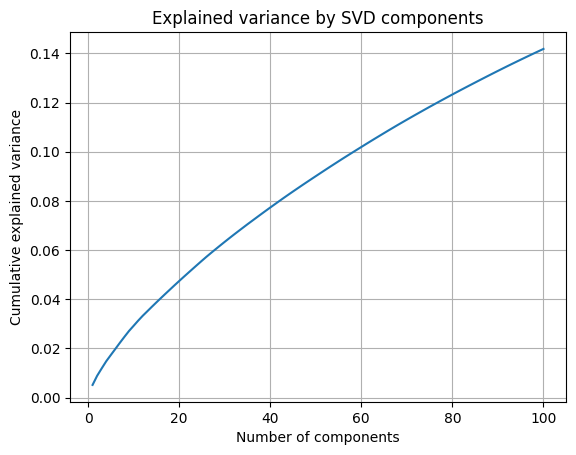

In [139]:

#lets use one hot encoding for rest of the features

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()


book_author_ft = ohe.fit_transform(df1[['Book-Author']])
book_publisher_ft = ohe.fit_transform(df1[['Publisher']])

n_components = 100
svd = TruncatedSVD(n_components = n_components)
reduced_author_ft = svd.fit_transform(book_author_ft)
reduced_publisher_ft = svd.fit_transform(book_publisher_ft)


In [140]:
#standardize the year of publication

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

df1['Year-Of-Publication'] = df1['Year-Of-Publication'].astype('str')
year_ft = sc.fit_transform(df1[['Year-Of-Publication']])

C:\Users\dhruv.goel1\AppData\Local\Temp\ipykernel_19912\2168242598.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Year-Of-Publication'] = df1['Year-Of-Publication'].astype('str')


In [141]:
#ensuring that the year of publication is also sparse matrix
from scipy.sparse import csr_matrix

year_ft_sparse = csr_matrix(year_ft)

In [ ]:
print("Shape of title features:", reduced_title_features.shape)
print("Shape of title features:", reduced_author_ft.shape)
print("Shape of title features:", reduced_publisher_ft.shape)
print("Shape of title features:", year_ft_sparse.shape)

Shape of title features: (1032341, 100)
Shape of title features: (1032341, 100)
Shape of title features: (1032341, 100)
Shape of title features: (1032341, 1)


In [144]:
# Combine features and convert to CSR format for efficient row slicing
feature_cols = hstack([reduced_title_features, reduced_author_ft, reduced_publisher_ft, year_ft_sparse]).tocsr()

In [145]:
df1.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Similarity_score
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2.0,0.0,-0.033141


In [146]:
user_id = 11676

user_data = df1[df1['User-ID'] == user_id]
print(user_data.shape)

#getting liked books
high_ratings = [7,8,9,10]
liked_books = user_data[user_data['Book-Rating'].isin(high_ratings)]
print(liked_books.shape)

(11144, 8)
(5002, 8)


In [147]:
#extract feature matrix for liked movies

liked_indices = liked_books.index
feature_matrix = feature_cols[liked_indices,:]
feature_matrix.shape

(5002, 301)

In [148]:
#getting rating matrix
rating_matrix = liked_books['Book-Rating'].values

In [149]:
#calculating the weighted sum

weighted_sum = feature_matrix.T @ rating_matrix
print(weighted_sum)

user_profile = weighted_sum/rating_matrix.sum()
print(user_profile)

#converting this into 2D vector
user_vector = user_profile.reshape(1,-1)
print(user_vector)

[ 8.61298257e+02  7.29230951e+02  2.40652535e+02  4.11562298e+02
  4.82145971e+02  4.34398130e+02 -1.12253792e+02  1.57213039e+02
  5.94997083e+00  4.19523601e+02 -2.95083452e+01 -1.76835601e+02
  3.30141529e+02  4.92215868e+01  1.32794517e+02 -5.82430720e+01
 -3.65835260e+01 -1.93422369e+01  1.68754421e+01  7.01601346e+01
 -3.76737104e+00 -2.70418165e+01  8.46417976e+01 -3.01060865e+01
  8.92923543e+01  8.63483514e+01  1.25696054e+02 -2.68113540e+01
 -1.39847770e+01  5.15944230e+01  6.53500812e+01  5.73767211e+01
  1.15134904e+01  5.86351019e+01  1.00382243e+02  1.14230643e+02
  8.29044848e+01  3.84499182e+01 -3.96088863e+01  1.13170633e+01
 -3.63645447e+01 -2.47234761e+01 -9.39145640e+00  7.96101176e+01
 -2.54234393e+01  1.10037102e+02  8.16972224e+01  1.09006246e+02
  9.51113010e+01  1.63437568e+02  9.78030225e+01  8.14241243e+01
 -3.78536043e+01  1.36442459e+02 -1.91255829e+01  2.42958538e+01
  1.28679289e+02 -2.82097248e+01  4.36819894e+01  3.41978344e+01
 -3.55674589e+01 -4.70088

In [150]:
feature_matrix_all_movies = feature_cols 

In [151]:
sim_score = cosine_similarity(user_vector, feature_matrix_all_movies).flatten()

In [152]:
df1['Similarity_score'] = sim_score

C:\Users\dhruv.goel1\AppData\Local\Temp\ipykernel_19912\602200502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Similarity_score'] = sim_score


In [153]:
df2 = df1.sort_values(by = ['Similarity_score'], ascending = [False])

In [156]:
user_data = df2[df2['User-ID'] == user_id]
already_rated_books = user_data['ISBN'].tolist()  # or 'ISBN' if you prefer

# Get candidate books (books not rated by user)
candidate_books = df2[~df2['ISBN'].isin(already_rated_books)]

In [158]:
# top 5 movies recommended for the particular user 11676

candidate_books_final = candidate_books.drop_duplicates(subset = ['ISBN'])
candidate_books_final.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Similarity_score
947332,0965064794,The Book Lover's Guide to the Internet,Evan Morris,0,Ballantine Books,252848.0,8.0,0.597543
36515,0345251733,Rainbow the Stormy Life of Judy Garland,Christopher Finch,0,Ballantine Books,51883.0,0.0,0.594625
634026,0345247302,Star Fleet Technical Manual Edition,Franz Joseph,0,Ballantine Books,32773.0,0.0,0.594218
973674,0345279816,Recipes for a Small Planet the Solution,Ellen Buchman Ewald,0,Ballantine Books,255092.0,10.0,0.594067
978249,0345276272,Tales of Known Space,Larry Niven,0,Ballantine Books,258875.0,6.0,0.593973


### Evaluating content based

In [159]:
train_df, test_df = train_test_split(df1, test_size=0.2, random_state=42)

# ------------------------
# 2. Prepare TF-IDF for book titles in the train set
# ------------------------
tfidf = TfidfVectorizer(stop_words='english')
book_title_ft = tfidf.fit_transform(train_df['Book-Title'])

# ------------------------
# 3. Apply Truncated SVD to reduce dimensions
# ------------------------
svd = TruncatedSVD(n_components=100)
reduced_title_ft = svd.fit_transform(book_title_ft)

# ------------------------
# 4. Build the user profile from books rated highly in the train set
# ------------------------
user_id = 11676
high_ratings = [7, 8, 9, 10]

# Get the user’s data from train set
user_data = train_df[train_df['User-ID'] == user_id]
liked_books = user_data[user_data['Book-Rating'].isin(high_ratings)]

if liked_books.empty:
    print("User has no highly rated books in the training set!")
else:
    liked_indices = liked_books.index
    feature_matrix_liked = reduced_title_ft[train_df.index.isin(liked_indices)]
    ratings = liked_books['Book-Rating'].values

    weighted_sum = feature_matrix_liked.T @ ratings
    user_profile = weighted_sum / ratings.sum()

    # ------------------------
    # 5. Compute similarity between user profile and all books in the train set
    # ------------------------
    sim_scores = cosine_similarity(user_profile.reshape(1, -1), reduced_title_ft).flatten()
    train_df = train_df.copy()
    train_df['Similarity'] = sim_scores

    # ------------------------
    # 6. Exclude books already rated by the user
    # ------------------------
    user_books = user_data['ISBN'].tolist()
    candidate_books = train_df[~train_df['ISBN'].isin(user_books)]
    candidate_books = candidate_books.drop_duplicates(subset=['ISBN'])

    # ------------------------
    # 7. Sort candidates by similarity and take top 5 recommendations
    # ------------------------
    recommendations = candidate_books.sort_values(by='Similarity', ascending=False)
    recommended_isbns = recommendations['ISBN'].tolist()[:5]

    print("Top 5 recommended books:")
    print(recommendations[['ISBN', 'Book-Title']].head())

    # ------------------------
    # 8. Get actual liked books from test set
    # ------------------------
    test_user_data = test_df[test_df['User-ID'] == user_id]
    actual_liked = test_user_data[test_user_data['Book-Rating'].isin(high_ratings)]['ISBN'].tolist()

    print("\nActual liked books in the test set:")
    print(actual_liked)

    # ------------------------
    # 9. Calculate Precision@5 and Recall@5
    # ------------------------
    if len(actual_liked) == 0:
        print("\nUser has no liked books in the test set!")
    else:
        precision = len(set(recommended_isbns) & set(actual_liked)) / 5
        recall = len(set(recommended_isbns) & set(actual_liked)) / len(actual_liked)

        print(f"\nPrecision@5: {precision}")
        print(f"Recall@5: {recall}")

Top 5 recommended books:
              ISBN                                         Book-Title
379690  0060914440  Skywriting by Word of Mouth : And Other Writin...
737671  0060156562  Skywriting by Word of Mouth: And Other Writing...
758738  0071355766  The Quotable Writer: Words of Wisdom from Mark...
924005  0385127367  The Shroud of Turin: The burial cloth of Jesus...
855632  0393039412  His Promised Land: The Autobiography of John P...

Actual liked books in the test set:
['0688058914', '0671871218', '0767912977', '0970101309', '2020043491', '0446606197', '0451454790', '0312977026', '0449146448', '0679722645', '039914840X', '0312137931', '0345386825', '0345430573', '0373483880', '0385312660', '0553277464', '0743400526', '030700645X', '0756400163', '0140306765', '0440221315', '0571086144', '0394620712', '0375719334', '0394925203', '0515132020', '0060809310', '0002258560', '0810920492', '0590401823', '006101351X', '0425189465', '0060534214', '0393047571', '0385335490', '0449911691',

In [160]:
print("Number of liked books in train:", len(liked_books))
print("Number of liked books in test:", len(actual_liked))

Number of liked books in train: 4029
Number of liked books in test: 973
